In [292]:
import pandas as pd
import numpy as np 
import skimage as skmg
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math 
from tqdm import tqdm
from random import *
from PIL import Image
import os
import time

#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
#from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
#from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import *
from sklearn.decomposition import PCA
#from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from skimage.util import random_noise
from scipy.stats import uniform

## Data Ingestion and Preprocessing

In [2]:
# Get the metadata and diagnoses
df = pd.read_csv("./HAM10000/HAM10000_metadata.csv")
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [21]:
# Label encoder for diagnoses
lb = LabelEncoder()
lb.fit_transform(df['dx'])
cls2lbl = {cls: idx for idx, cls in enumerate(lb.classes_)}
lbl2cls = {idx: cls for idx, cls in enumerate(lb.classes_)}
df['label'] = [cls2lbl[cls] for cls in df['dx']]

In [3]:
# Read in images 
sds = ["./HAM10000/HAM10000_images_part_1/", "./HAM10000/HAM10000_images_part_2/"]
dir = "HAM10000/HAM10000_segmentations_lesion_tschandl/HAM10000_segmentations_lesion_tschandl/"
imgs = []
masks = []

# Get the images
for sd in sds:
    filelist = [f for f in os.listdir(sd)]
    for file in tqdm(filelist):
        imgs.append(mpimg.imread(sd+file))

# Get segmentation masks      
masklist = [f for f in os.listdir(dir)]   
for f in tqdm(masklist):
    masks.append(mpimg.imread(dir+f))

100%|██████████| 10015/10015 [00:47<00:00, 210.43it/s]


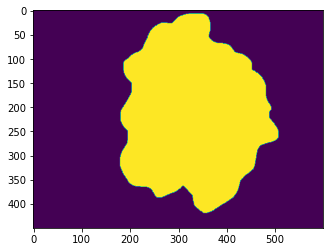

In [315]:
plt.imshow(masks[0])

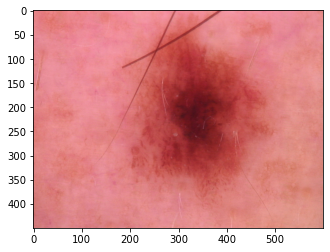

In [316]:
plt.imshow(imgs[0])

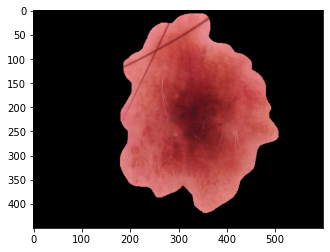

In [326]:
# Application of segmentation mask
for d in range(3):
    new_img[:,:,d] = np.multiply(imgs[0][:,:,d], masks[0])
plt.imshow(new_img)

In [49]:
# Read in external test set
#test_imgs = []
#testdir = "./HAM10000/ISIC2018_Task3_Test_Images/ISIC2018_Task3_Test_Images/"
#testlist = [f for f in os.listdir(testdir)]   
#for f in tqdm(testlist):
    #test_imgs.append(mpimg.imread(testdir+f))

100%|██████████| 1511/1511 [00:15<00:00, 96.42it/s] 


In [310]:
# Generate a new image by randomly transforming an existing one 
def augment_image(img):
    aug_img = img
    # Random flips 
    if random()<=0.5: 
        aug_img = np.fliplr(aug_img)
    if random()<=0.5:
        aug_img = np.flipud(aug_img)
    aug_img = skmg.transform.rotate(aug_img, angle=random()*360, mode = 'edge') # Random rotation
    aug_img = skmg.util.random_noise(aug_img)
    return aug_img

In [127]:
df["img"] = imgs

In [128]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,img
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,"[[[221, 131, 131], [222, 128, 126], [223, 129,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,"[[[213, 123, 135], [215, 122, 133], [219, 123,..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,"[[[242, 169, 178], [246, 173, 182], [246, 173,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,"[[[207, 119, 131], [214, 123, 140], [207, 119,..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,"[[[73, 32, 36], [71, 35, 37], [73, 33, 42], [7..."


In [132]:
df["dx"].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [149]:
nv_df.shape

(6705, 10)

In [142]:
6705/10015

0.6694957563654518

In [145]:
nv_sample_df = nv_df.sample(n = (df.shape[0]-nv_df.shape[0]))
nv_sample_df.shape

(3310, 9)

In [ ]:
image_rescaled = rescale(imgs[0], 0.25, multichannel=True)
plt.imshow(image_rescaled)

In [5]:
# downsize images by factor of 4
imgs_rescaled = [rescale(img, 0.25, multichannel=True) for img in tqdm(imgs)]

100%|██████████| 10015/10015 [03:45<00:00, 44.43it/s]


In [7]:
imgs_rescaled[0].shape

(112, 150, 3)

In [6]:
red_channel = [imgs_rescaled[n][:,:,0].flatten() for n in tqdm(range(len(imgs_rescaled)))]
b_channel = [imgs_rescaled[n][:,:,1].flatten() for n in tqdm(range(len(imgs_rescaled)))]
g_channel = [imgs_rescaled[n][:,:,2].flatten() for n in tqdm(range(len(imgs_rescaled)))]

100%|██████████| 10015/10015 [00:00<00:00, 10319.59it/s]


In [12]:
red_channel[0]

array([0.88630952, 0.89411765, 0.89803922, ..., 0.84021359, 0.82160364,
       0.82160364])

In [17]:
def rescale_channels(channel):
    scaler = MinMaxScaler()
    return scaler.fit_transform(channel)

In [18]:
# Perform rescaling for each color channel 
rescaled_red = rescale_channels(red_channel)
rescaled_g = rescale_channels(g_channel)
rescaled_b = rescale_channels(b_channel)

In [19]:
imgs_normalized = [np.concatenate((rescaled_red[n], rescaled_g[n], rescaled_b[n])) for n in tqdm(range(len(imgs_rescaled)))]

100%|██████████| 10015/10015 [00:04<00:00, 2130.72it/s]


(array([ 1617.,  2251.,  2647.,  2639.,  9546., 15384.,  1325.,  1559.,
         4672.,  8760.]),
 array([0.07842196, 0.16674441, 0.25506687, 0.34338932, 0.43171177,
        0.52003423, 0.60835668, 0.69667914, 0.78500159, 0.87332405,
        0.9616465 ]),
 <BarContainer object of 10 artists>)

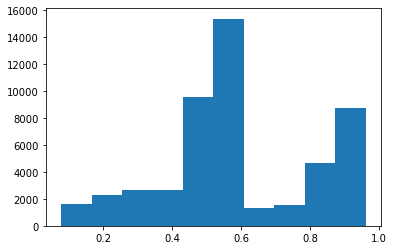

In [20]:
plt.hist(imgs_normalized[0]) # Check normalization 

In [146]:
df["norm_img"] = imgs_normalized

In [147]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,img,norm_img
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,"[[[221, 131, 131], [222, 128, 126], [223, 129,...","[0.8897989313835777, 0.8976377952755905, 0.903..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,"[[[213, 123, 135], [215, 122, 133], [219, 123,...","[0.8435215129358833, 0.8513603768278963, 0.855..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,"[[[242, 169, 178], [246, 173, 182], [246, 173,...","[0.9645669291338583, 0.9645669291338583, 0.966..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,"[[[207, 119, 131], [214, 123, 140], [207, 119,...","[0.805082958380202, 0.8149957817772785, 0.8224..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,"[[[73, 32, 36], [71, 35, 37], [73, 33, 42], [7...","[0.2755905511811024, 0.276557227221597, 0.2672..."


In [170]:
nv_df = df[df["dx"] == "nv"]
mel_df = df[df["dx"] == "mel"]

In [171]:
mel_df.shape[0]

1113

In [172]:
nv_sample = nv_df.sample(n = mel_df.shape[0])

In [173]:
nv_sample.shape

(1113, 10)

In [153]:
nv_sample.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,img,norm_img
5264,HAM_0005638,ISIC_0030201,nv,follow_up,50.0,female,lower extremity,5,"[[[120, 92, 91], [123, 94, 96], [126, 96, 98],...","[0.4901574803149608, 0.4970648200224975, 0.500..."
3891,HAM_0002165,ISIC_0031172,nv,follow_up,55.0,male,lower extremity,5,"[[[175, 149, 134], [178, 150, 138], [179, 151,...","[0.7047244094488189, 0.7145669291338586, 0.715..."
3813,HAM_0000455,ISIC_0032005,nv,follow_up,50.0,female,back,5,"[[[192, 115, 151], [192, 112, 149], [191, 115,...","[0.7519685039370079, 0.7568721878515184, 0.771..."
5798,HAM_0004906,ISIC_0028522,nv,follow_up,35.0,male,lower extremity,5,"[[[197, 132, 140], [198, 128, 138], [196, 130,...","[0.7627776996625418, 0.762777699662542, 0.7711..."
2976,HAM_0004932,ISIC_0032212,nv,follow_up,45.0,female,foot,5,"[[[189, 140, 133], [192, 145, 137], [191, 147,...","[0.754938835770529, 0.7696850393700789, 0.7721..."


In [196]:
nv_sample["label"].unique()

array([5], dtype=int64)

In [158]:
other_df = df[df["dx"] != "nv"]
other_df.shape
other_df["label"].unique() # Confirm contains all classes except nv

array([2, 3, 4, 6, 1, 0], dtype=int64)

In [210]:
resampled_imgs = np.concatenate((nv_sample['norm_img'].to_numpy(), other_df["norm_img"].to_numpy())).tolist()
len(resampled_imgs)

4423

In [177]:
resampled_labels = nv_sample["label"].tolist()+other_df["label"].tolist()
len(resampled_labels)

4423

In [203]:
len(resampled_imgs[0])

50400

In [204]:
len(imgs_normalized[0])

50400

In [222]:
# Apply PCA for dimensionality reduction 
# Runetime: 8 mins. 
seconds = time.time()
pca_resampled = PCA(n_components = 0.95) # 90% of variation 
pca_resampled.fit(resampled_imgs)
print(pca_resampled.explained_variance_ratio_)
print("Runtime (s)", seconds)

[0.30623859 0.20926622 0.11414701 0.04152863 0.03692638 0.0354532
 0.01988143 0.0180786  0.01572275 0.01475436 0.01317953 0.01027058
 0.00814836 0.00657235 0.00633152 0.00537422 0.00505966 0.00485488
 0.00463144 0.00412417 0.00318721 0.00299954 0.00280799 0.00264244
 0.00257531 0.00247642 0.0023494  0.0021561 ]
Runtime (s) 1666850267.928042


In [223]:
principalComponents_resampled = pca_resampled.transform(resampled_imgs)
principalComponents_resampled[0].shape

(28,)

In [253]:
# Apply PCA for dimensionality reduction 
seconds = time.time()
pca_resampled2 = PCA(n_components = 0.95) # 95% of variation 
pca_resampled2.fit(resampled_imgs)
print(pca_resampled2.explained_variance_ratio_)
print("Runtime (s)", seconds)

[3.06238595e-01 2.09266218e-01 1.14147013e-01 4.15286296e-02
 3.69263810e-02 3.54532029e-02 1.98814301e-02 1.80786025e-02
 1.57227468e-02 1.47543562e-02 1.31795311e-02 1.02705811e-02
 8.14836462e-03 6.57235404e-03 6.33152433e-03 5.37422361e-03
 5.05965688e-03 4.85488499e-03 4.63144056e-03 4.12416970e-03
 3.18721493e-03 2.99953745e-03 2.80798865e-03 2.64243847e-03
 2.57530734e-03 2.47642002e-03 2.34940272e-03 2.15610050e-03
 1.99715594e-03 1.95932377e-03 1.61613329e-03 1.43578185e-03
 1.42172609e-03 1.35246714e-03 1.30675218e-03 1.25861902e-03
 1.23040010e-03 1.20198885e-03 1.17439854e-03 1.11734684e-03
 1.09047632e-03 1.06935576e-03 1.03140838e-03 9.68494889e-04
 9.42364873e-04 8.89848452e-04 8.71169184e-04 8.40927685e-04
 8.09779645e-04 8.03490558e-04 7.94741561e-04 7.62396609e-04
 7.27338690e-04 7.01465543e-04 6.86819816e-04 6.60248758e-04
 6.36891787e-04 6.22179575e-04 5.97278048e-04 5.85698995e-04
 5.75163599e-04 5.44897272e-04 5.28770713e-04 5.23401083e-04
 5.01190032e-04 4.920806

In [254]:
principalComponents_resampled2 = pca_resampled2.transform(resampled_imgs)
principalComponents_resampled2[0].shape

(99,)

In [22]:
# Apply PCA for dimensionality reduction 
# Warning: Long runtime 
seconds = time.time()
pca = PCA(n_components = 0.9) # 90% of variation 
pca.fit(imgs_normalized)
print(pca.explained_variance_ratio_)
print("Runtime (s)", seconds)

[0.29350167 0.21523472 0.11910315 0.04148486 0.03651563 0.03534689
 0.02110287 0.01815903 0.01559823 0.01492415 0.01282237 0.01053648
 0.00799169 0.00644176 0.00637539 0.00532914 0.00524701 0.00508448
 0.00458079 0.0042688  0.00324756 0.00296647 0.00280418 0.00271995
 0.00261565 0.00252722 0.00238299 0.0021236 ]


In [23]:
principalComponents = pca.transform(imgs_normalized)

In [139]:
# The number of components returned by PCA 
principalComponents[0].shape

(28,)

## Baseline Model Training and Evaluation

In [135]:
# Perform train-test split for full-image dataset
# Input vector size = 50400
x_train, x_test, y_train, y_test = train_test_split(imgs_normalized, df["label"], test_size=0.2, random_state=0, stratify = df["label"])

In [217]:
# Perform train test split for principal component dataset
# Input vector size = 28
x_train, x_test, y_train, y_test = train_test_split(principalComponents, df["dx"], random_state=0, test_size=0.2, stratify = df["label"])

In [224]:
# Perform train-test split for resampled dataset
# Input vector size = 50400
x_train, x_test, y_train, y_test = train_test_split(resampled_imgs, resampled_labels, test_size=0.2, random_state=0, stratify = resampled_labels)

In [227]:
# Perform train-test split for resampled principle component dataset
# Input vector size = 28
x_train, x_test, y_train, y_test = train_test_split(principalComponents_resampled, resampled_labels, test_size=0.2, random_state=0, stratify = resampled_labels)

In [256]:
# Perform train-test split for resampled principal component dataset, 95% variance
# Input vector size = 99
x_train, x_test, y_train, y_test = train_test_split(principalComponents_resampled2, resampled_labels, test_size=0.2, random_state=0, stratify = resampled_labels)

In [ ]:
# Run randomized search for hyperparameter tuning 
def hyperparameter_tuning(model, param_grid):
    param_search = RandomizedSearchCV(model, param_grid, random_state=0).fit(x_train, y_train)
    return param_search.best_params_

In [ ]:
# Plot confusion matrix
def plot_confusion(model, x, y):
    plt.figure(figsize=(9,9))
    sns.heatmap(confusion_matrix(y, model.predict(x)), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(model.score(x, y))
    plt.title(str(model)+" Performance", size = 15);
    

### Logistic Regression

In [263]:
# Train logistic regression model 
logistic_model = LogisticRegression(max_iter = 1000, multi_class = 'multinomial', C = 3.3770629943240693, solver = 'saga')

In [262]:
# Run randomized search for hyperparameter tuning 
logistic_param_grid = {"C":uniform(loc=0, scale=4), "solver":['newton-cg', 'lbfgs', 'sag', 'saga']}
log_search = RandomizedSearchCV(logistic_model, logistic_param_grid, random_state=0).fit(x_train, y_train)
log_search.best_params_

C:\Users\wchen\.conda\envs\derm_classify\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\wchen\.conda\envs\derm_classify\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\wchen\.conda\envs\derm_classify\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\wchen\.conda\envs\derm_classify\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


{'C': 3.3770629943240693, 'solver': 'saga'}

In [264]:
logistic_model.fit(x_train, y_train)
# {'C': 2.195254015709299, 'solver': 'lbfgs'}

LogisticRegression(C=3.3770629943240693, max_iter=1000,
                   multi_class='multinomial', solver='saga')

In [266]:
print("Accuracy on test set: "+str(logistic_model.score(x_test, y_test)))
print("AUC Score: "+ str(roc_auc_score(y_test, logistic_model.predict_proba(x_test), multi_class='ovr')))

Accuracy on test set: 0.2497175141242938
AUC Score: 0.5641938178039504


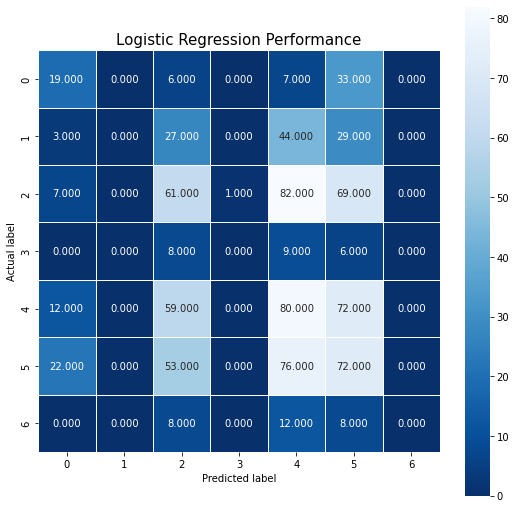

In [231]:
# Plot confusion matrix 
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(y_test, logistic_model.predict(x_test)), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(logistic_model.score(x_test, y_test))
plt.title("Logistic Regression Performance", size = 15);

### Support Vector Machine

In [239]:
# Support Vector Classifier Training
svc_model = SVC(gamma='auto')

SVC(gamma='auto')

In [267]:
# Run randomized search for hyperparameter tuning 
svc_param_grid = {"C":uniform(loc=0, scale=5), "kernel":['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 
                  "shrinking":[True, False]}
svc_search = RandomizedSearchCV(svc_model, svc_param_grid, random_state=0).fit(x_train, y_train)
svc_search.best_params_

KeyboardInterrupt: 

In [240]:
svc_model.fit(x_train, y_train)
svc_model.score(x_test, y_test)

0.2677966101694915

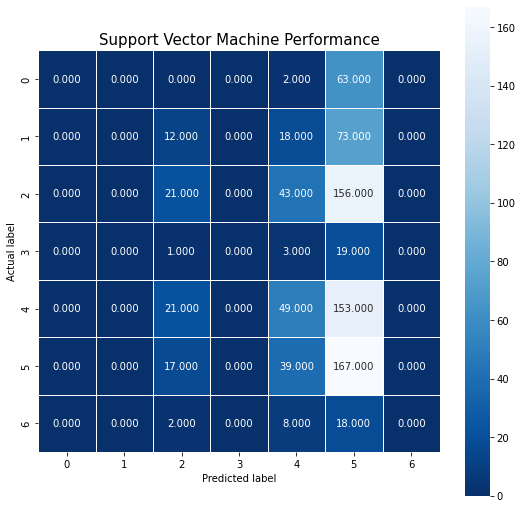

In [241]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(y_test, svc_model.predict(x_test)), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(svc_model.score(x_test, y_test))
plt.title("Support Vector Machine Performance", size = 15);

### Random Forest

In [242]:
# Random Forest Training
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0)
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=0)

In [ ]:
rf_param_grid = {"n_estimators":[n for n in range(1, 500)], "max_depth":["None"]+[n for n in range(1, 50)], 
                 "criterion":["gini", "entropy", "log_loss"], "min_samples_split":[n for n in range(2, 11)],
                 "min_samples_leaf":[n for n in range(1, 11)], "max_features":["sqrt", "log2", None]}
rf_search = RandomizedSearchCV(rf_model, rf_param_grid, random_state=0).fit(x_train, y_train)
rf_search.best_params_

In [243]:
rf_model.score(x_test, y_test)

0.27231638418079096

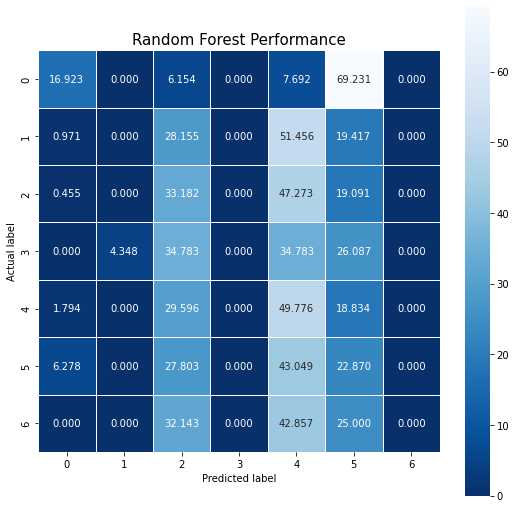

In [187]:
cm = confusion_matrix(y_test, rf_model.predict(x_test), normalize = 'true')
plt.figure(figsize=(9,9))
sns.heatmap(cm*100, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(rf_model.score(x_test, y_test))
plt.title("Random Forest Performance", size = 15);

### Multi-Layer Perceptron

In [246]:
# Train multi-layer perceptron
mlp_model = MLPClassifier(random_state=1, max_iter=1000)
mlp_model.fit(x_train, y_train)

MLPClassifier(max_iter=1000, random_state=1)

In [ ]:
# Run randomized search for hyperparameter tuning 
mlp_param_grid = {"C":uniform(loc=0, scale=5), "kernel":['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 
                  "shrinking":[True, False]}
mlp_search = RandomizedSearchCV(svc_model, svc_param_grid, random_state=0).fit(x_train, y_train)
mlp_search.best_params_

In [247]:
mlp_model.score(x_test, y_test)

0.24293785310734464

### K-Nearest Neighbors

In [244]:
# Knn
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.27231638418079096

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(y_test, knn.predict(x_test), normalize = 'true')*100, annot=True, fmt=".3f", linewidths=.5, 
            square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(knn.score(x_test, y_test))
plt.title("KNN Classifier Performance", size = 15);

In [249]:
# Gradient boosting
grad_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0).fit(x_train, y_train)
grad_boost.score(x_test, y_test)

0.25310734463276835

## Data Augmentation

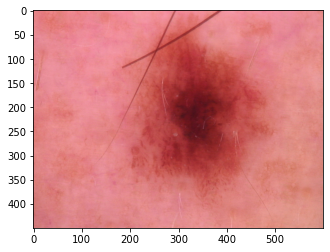

In [270]:
plt.imshow(imgs[0])

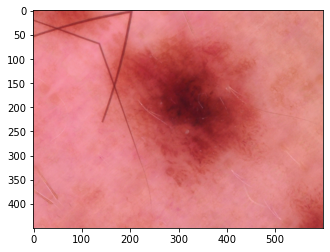

In [308]:
plt.imshow(skmg.transform.rotate(imgs[0], angle = 45, mode = ""))

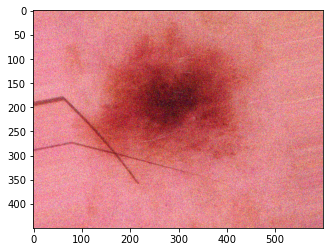

In [312]:
plt.imshow(augment_image(imgs[0]))

In [296]:
skmg.transform.rotate

<function skimage.transform._warps.rotate(image, angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True, preserve_range=False)>